In [3]:
import torch
import torch.nn as nn
import numpy as np

MIN_RANGE = -128
MAX_RANGE = 127

def quantize(tensor, new_min=MIN_RANGE, new_max=MAX_RANGE, dtype=torch.float32):
    min_val = torch.min(tensor, axis=-1).values.unsqueeze(-1)
    max_val = torch.max(tensor, axis=-1).values.unsqueeze(-1)
    scale = (new_max - new_min) / (max_val - min_val)
    result = torch.round((tensor - min_val) * scale + new_min).to(dtype)
    bias = new_min - scale * min_val
    return result, scale[...,0], bias[...,0]

def int8_32_matmul(a, b):
    return torch.matmul(a,b)

def dequantize(tensor, scale, bias, dtype=torch.float32):
    return ((tensor.to(dtype) - bias.unsqueeze(-1)) / scale.unsqueeze(-1)).to(dtype)

class QuantizedMatrix:
    def __init__(self, matrix, min_range=MIN_RANGE, max_range=MAX_RANGE):
        self.matrix = matrix
        self.min_range = min_range
        self.max_range = max_range
        
        (self.q, self.s, self.b) = quantize(self.matrix, new_min=self.min_range, new_max=self.max_range)
        self.q_minus_b = (self.q - self.b.unsqueeze(-1)).sum(axis=-1)
        self.inv_s = 1./self.s
        
    def __matmul__(self, other) -> np.ndarray:
        z = int8_32_matmul(self.q, other.q.T)
        E_1 = torch.einsum('bi,j->bij', -self.b, other.q_minus_b)
        E_2 = torch.einsum('bi,j->bij', self.q.sum(axis=-1), -other.b)
        res = torch.einsum('bij,bi,j->bij', z + E_1 + E_2, self.inv_s, other.inv_s)
        return res
    
    def dequantize(self):
        return dequantize(self.q, self.s, self.b)
    

In [4]:
import numpy as np
from typing import List
import math

def permute_matrix_operation(a: np.ndarray, permutations: np.ndarray, matrices: np.ndarray):
    n = len(a)
    assert n == 2 ** int(math.log2(n))
    assert len(a.shape) == 2
    assert all(matrix.shape == (n//2, 2, 2) for matrix in matrices)
    assert all(set(permutation) == set(range(n)) for permutation in permutations)

    # for every layer in circuit
    for permutation, matrix in zip(permutations, matrices): 
        new_a = np.zeros_like(a)
        a = a[permutation]
        new_a[::2] = a[::2] * matrix[:,0,0].reshape(n//2, 1) + a[1::2] * matrix[:,0,1].reshape(n//2, 1)
        new_a[1::2] = a[::2] * matrix[:,1,0].reshape(n//2, 1) + a[1::2] * matrix[:,1,1].reshape(n//2, 1)
        a[permutation] = new_a
        
    return a

In [5]:
np.set_printoptions(precision=2)

n = 16
a = np.eye(n, dtype=np.complex64)
permutations = []
matrices = []

for s in range(1, int(np.log2(n)) + 1):
    matrix = []
    permutation = []
    
    m = 2**s
    omega_m = np.exp(2j * np.pi / m)
    
    for k in range(0, n, m):
        omega = 1
        for j in range(0, m//2):
            matrix.append([[1, omega], [1, -omega]])
            permutation.append(k+j)
            permutation.append(k+j+m//2)        
            omega = omega * omega_m
        
    permutations.append(np.array(permutation))
    matrices.append(np.array(matrix))
    
def bit_reversal(x, n):
    result = 0
    for i in range(n):
        result = (result << 1) | (x & 1)
        x >>= 1
    return result

def bit_reversal_range(n):
    return [bit_reversal(i, int(np.log2(n))) for i in range(n)]

permute_matrix_operation(a[bit_reversal_range(n)], permutations, matrices)

array([[ 1.00e+00+0.j  ,  1.00e+00+0.j  ,  1.00e+00+0.j  ,
         1.00e+00+0.j  ,  1.00e+00+0.j  ,  1.00e+00+0.j  ,
         1.00e+00+0.j  ,  1.00e+00+0.j  ,  1.00e+00+0.j  ,
         1.00e+00+0.j  ,  1.00e+00+0.j  ,  1.00e+00+0.j  ,
         1.00e+00+0.j  ,  1.00e+00+0.j  ,  1.00e+00+0.j  ,
         1.00e+00+0.j  ],
       [ 1.00e+00+0.j  ,  9.24e-01+0.38j,  7.07e-01+0.71j,
         3.83e-01+0.92j,  6.12e-17+1.j  , -3.83e-01+0.92j,
        -7.07e-01+0.71j, -9.24e-01+0.38j, -1.00e+00+0.j  ,
        -9.24e-01-0.38j, -7.07e-01-0.71j, -3.83e-01-0.92j,
        -6.12e-17-1.j  ,  3.83e-01-0.92j,  7.07e-01-0.71j,
         9.24e-01-0.38j],
       [ 1.00e+00+0.j  ,  7.07e-01+0.71j,  2.22e-16+1.j  ,
        -7.07e-01+0.71j, -1.00e+00+0.j  , -7.07e-01-0.71j,
        -2.22e-16-1.j  ,  7.07e-01-0.71j,  1.00e+00+0.j  ,
         7.07e-01+0.71j,  2.22e-16+1.j  , -7.07e-01+0.71j,
        -1.00e+00+0.j  , -7.07e-01-0.71j, -2.22e-16-1.j  ,
         7.07e-01-0.71j],
       [ 1.00e+00+0.j  ,  3.83e-01+0.

In [6]:
n = 16
a = np.eye(n, dtype=int)
permutations = []
matrices = []

for s in range(1, int(np.log2(n)) + 1):
    matrix = []
    permutation = []
    
    m = 2**s
    
    for k in range(0, n, m):
        for j in range(0, m//2):
            matrix.append([[1, 1], [1, -1]])
            permutation.append(k+j)
            permutation.append(k+j+m//2)        
        
    permutations.append(np.array(permutation))
    matrices.append(np.array(matrix))

permute_matrix_operation(a, permutations, matrices)

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1],
       [ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1],
       [ 1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1],
       [ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1],
       [ 1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1],
       [ 1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1],
       [ 1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1],
       [ 1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,

In [7]:
n = 1024
l = []
for i in range(1000000):
    a = np.random.randint(-128, 128, size=(n,1), dtype=np.int8)
    b = np.random.randint(-128, 128, size=(1,n), dtype=np.int8)
    l.append((b@a)[0,0])


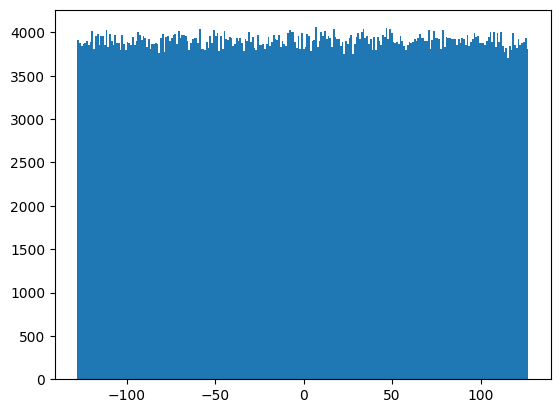

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(list(l), bins=256)
plt.show()

In [9]:
def invert_matrices(matrices):
    matrices_shape = matrices.shape
    matrices = matrices.reshape((-1,2,2))
    pinv = np.linalg.pinv(matrices)
    return pinv.reshape(matrices_shape)

def invert_permutations(permutations):
    rows = np.arange(permutations.shape[0])[:, np.newaxis]
    new_permutations = np.zeros_like(permutations)
    new_permutations[rows, permutations] = np.arange(permutations.shape[1])
    return new_permutations

In [10]:
p = 101

def extended_gcd(x, y):
    if y == 0:
        return x, 1, 0
    gcd, a1, b1 = extended_gcd(y, x % y)
    a = b1
    b = a1 - (x // y) * b1
    return gcd, a, b

def generate_random_unimodal_matrix(p=101):
    while True:
        x, y = np.random.randint(-p,p), np.random.randint(-p,p)
        gcd, a, b = extended_gcd(x, y)
        if gcd == 1:
            mat = np.array([[x, y],
                            [-b, a]])
            mat_perm = np.zeros_like(mat)
            mat_perm[np.random.permutation(2)] = mat
            return mat_perm

In [16]:
# from utils import plot_error
from scipy.stats import ortho_group

n = 128
r = 128
k = 7
np.random.seed(1333)

mat = np.eye(n).astype(np.float64)
permutations = np.array([np.random.permutation(n) for _ in range(k)])
matrices = np.array([ortho_group.rvs(size=128 // 2, dim=2) for _ in range(k)]).reshape((k, n//2, 2, 2))
perm_mat = permute_matrix_operation(mat, permutations, matrices)
inverse_matrices = invert_matrices(matrices)

reconstructed_mat = permute_matrix_operation(perm_mat, permutations[::-1], inverse_matrices[::-1])
print(f"{mat=}")
print(f"{reconstructed_mat=}")
print(f"{perm_mat=}")
assert (np.allclose(mat, reconstructed_mat))

mat=array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
reconstructed_mat=array([[ 1.00e+00, -1.37e-17, -8.33e-17, ...,  1.74e-19,  2.02e-17,
         2.75e-18],
       [ 8.25e-18,  1.00e+00,  4.44e-18, ...,  4.31e-18,  2.97e-17,
         1.46e-17],
       [ 3.89e-16,  1.22e-17,  1.00e+00, ...,  6.33e-18, -2.31e-18,
        -5.20e-18],
       ...,
       [ 2.73e-18, -6.91e-18,  7.72e-18, ...,  1.00e+00,  5.13e-17,
        -1.64e-17],
       [ 4.12e-17, -3.24e-17,  6.12e-18, ...,  4.19e-17,  1.00e+00,
         4.14e-17],
       [ 5.39e-18,  2.09e-17,  2.78e-18, ..., -1.09e-17,  2.33e-17,
         1.00e+00]])
perm_mat=array([[ 6.25e-03, -2.35e-01,  3.68e-02, ..., -3.49e-04, -0.00e+00,
         1.20e-02],
       [-4.29e-04,  1.27e-02,  7.27e-05, ...,  3.22e-01,  0.00e+00,
        -5.24e-03],
       [-1.

In [200]:
255/15

17.0

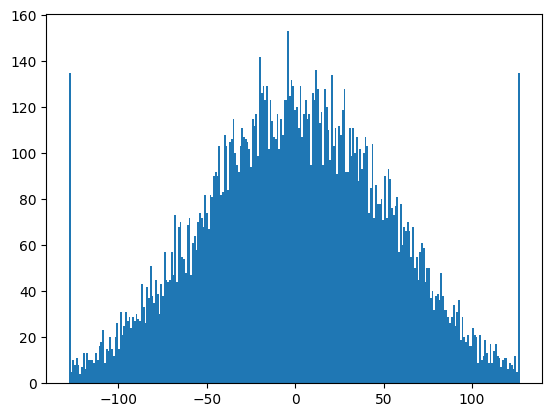

In [201]:
plt.figure()
plt.hist(QuantizedMatrix(torch.from_numpy(perm_mat)).q.ravel(), bins=256)
plt.show()

In [198]:
QuantizedMatrix(torch.from_numpy(perm_mat)).s

tensor([0.0012, 0.0012, 0.0015, 0.0011, 0.0014, 0.0012, 0.0017, 0.0013, 0.0014,
        0.0011, 0.0011, 0.0012, 0.0011, 0.0013, 0.0012, 0.0011, 0.0016, 0.0012,
        0.0013, 0.0010, 0.0012, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0012,
        0.0014, 0.0011, 0.0014, 0.0013, 0.0018, 0.0013, 0.0012, 0.0012, 0.0013,
        0.0012, 0.0012, 0.0012, 0.0009, 0.0011, 0.0013, 0.0012, 0.0012, 0.0011,
        0.0015, 0.0016, 0.0013, 0.0012, 0.0012, 0.0014, 0.0017, 0.0013, 0.0011,
        0.0011, 0.0013, 0.0012, 0.0014, 0.0014, 0.0014, 0.0012, 0.0013, 0.0014,
        0.0011, 0.0012, 0.0013, 0.0012, 0.0011, 0.0012, 0.0012, 0.0013, 0.0013,
        0.0014, 0.0015, 0.0013, 0.0014, 0.0014, 0.0014, 0.0012, 0.0011, 0.0015,
        0.0015, 0.0013, 0.0011, 0.0011, 0.0011, 0.0013, 0.0014, 0.0012, 0.0011,
        0.0013, 0.0013, 0.0013, 0.0014, 0.0012, 0.0013, 0.0012, 0.0013, 0.0012,
        0.0013, 0.0010, 0.0015, 0.0013, 0.0012, 0.0014, 0.0011, 0.0012, 0.0015,
        0.0014, 0.0013, 0.0013, 0.0013, 

In [123]:
np.percentile(perm_mat.ravel(), 99) - np.percentile(perm_mat.ravel(), 1)

1339.62

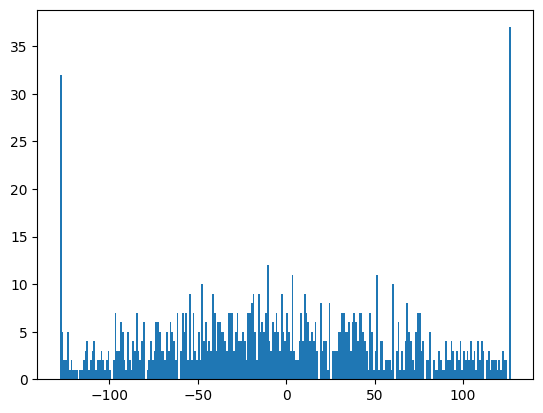

In [124]:
plt.figure()
plt.hist(QuantizedMatrix(torch.from_numpy(perm_mat)).q.ravel(), bins=np.arange(-128,128))
plt.show()

In [ ]:
perm_mat

In [ ]:
perm_mat.min()

In [ ]:
np.linalg.norm(perm_mat, ord=1, axis=-1)

In [ ]:
perm_mat.max(axis=-1)

In [ ]:
perm_mat

In [ ]:
plt.figure()
plt.hist(perm_mat.ravel(), bins=256)
plt.show()

In [ ]:
mat

(32, 32) (32, 32)
(9765, 1024) (9765, 1024)
(9999360,)


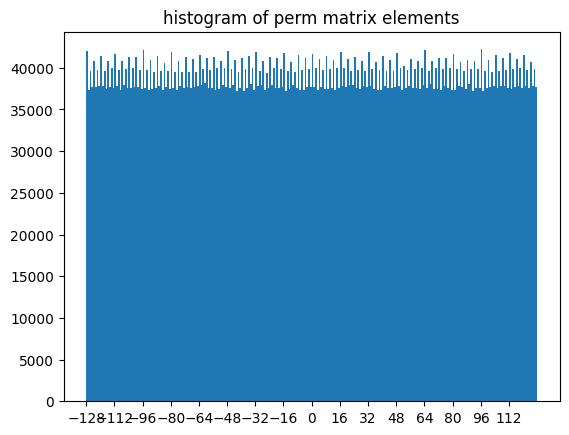

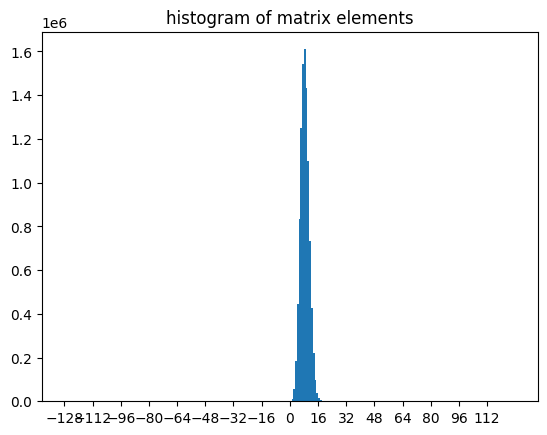

In [125]:
import matplotlib.pyplot as plt

np.random.seed(1337)

perm_mat_elements = []
mat_elements = []

for _ in range(10000):
    a = np.random.choice([0,1], size=(n,r)) 
    b = np.random.choice([0,1], size=(r,n))
    mat = (a @ b).astype(np.int32)
    # mat = np.random.randint(-1, 1, size=(n,n), dtype=np.int32)
    permutations = np.array([np.random.permutation(n) for _ in range(k)])
    matrices = np.array([2 * np.random.randint(-64, 64, size=(n//2, 2, 2)) + 1 for _ in range(k)])
    if not all(np.linalg.det(m) != 0 for m in matrices.reshape((-1,2,2))) or np.linalg.slogdet(mat) == 0:
        continue
    
    perm_mat = permute_matrix_operation(mat, permutations, matrices)
    perm_mat_elements.append(perm_mat.astype(np.int8).ravel())
    mat_elements.append(mat.astype(np.int8).ravel())

print(mat.shape, perm_mat.shape)
print(np.array(perm_mat_elements).shape, np.array(mat_elements).shape)
print(np.array(perm_mat_elements).flatten().shape)
plt.figure()
plt.title('histogram of perm matrix elements')
plt.hist(np.array(perm_mat_elements).flatten(), bins=np.arange(-128, 129))
plt.xticks(np.arange(-128, 128, 16))
plt.show()

plt.figure()
plt.title('histogram of matrix elements')
plt.hist(np.array(mat_elements).flatten(), bins=np.arange(-128, 129))
plt.xticks(np.arange(-128, 128, 16))
plt.show()